Download packages

In [62]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import warnings
from sklego.meta import OrdinalClassifier
from sklearn.inspection import DecisionBoundaryDisplay
import scipy
from sklearn.metrics import balanced_accuracy_score

In [2]:
random.seed(8)

Create new feature names to take the mean and std across epochs pr person

In [3]:
m_list = ['Delta', 'Delta_N', 'Theta', 'Theta_N', 'Alpha', 'Alpha_N', 'Beta', 'Beta_N', 'Gamma', 'Gamma_N', 'SE', 'MSF', 'Sef90', 'Sef95', 'PE', 'wSMI', 'Kolmogorov', 'MeanRR', 'StdRR', 'MeanHR', 'StdHR', 'MinHR', 'MaxHR'] 
mean_list = [i + '_mean' for i in m_list]
std_list = [i + '_std' for i in m_list]
print(mean_list)

['Delta_mean', 'Delta_N_mean', 'Theta_mean', 'Theta_N_mean', 'Alpha_mean', 'Alpha_N_mean', 'Beta_mean', 'Beta_N_mean', 'Gamma_mean', 'Gamma_N_mean', 'SE_mean', 'MSF_mean', 'Sef90_mean', 'Sef95_mean', 'PE_mean', 'wSMI_mean', 'Kolmogorov_mean', 'MeanRR_mean', 'StdRR_mean', 'MeanHR_mean', 'StdHR_mean', 'MinHR_mean', 'MaxHR_mean']


Concatenate data

In [4]:
path ='CSV_individual_cross_val/'
folder = os.fsencode(path)
renamed_markers_list = ['No.', 'Event', 'Delta', 'Delta_N', 'Theta', 'Theta_N', 'Alpha', 'Alpha_N', 'Beta', 'Beta_N', 'Gamma', 'Gamma_N', 'SE', 'MSF', 'Sef90', 'Sef95', 'PE', 'wSMI', 'Kolmogorov', 'MeanRR', 'StdRR', 'MeanHR', 'StdHR', 'MinHR', 'MaxHR', 'freq_slope_mean','freq_slope_std'] 
m_list = ['Delta', 'Delta_N', 'Theta', 'Theta_N', 'Alpha', 'Alpha_N', 'Beta', 'Beta_N', 'Gamma', 'Gamma_N', 'SE', 'MSF', 'Sef90', 'Sef95', 'PE', 'wSMI', 'Kolmogorov', 'MeanRR', 'StdRR', 'MeanHR', 'StdHR', 'MinHR', 'MaxHR', 'freq_slope_mean','freq_slope_std'] 
mean_list = [i + '_mean' for i in m_list]
std_list = [i + '_std' for i in m_list]


patient_numbers = []
r_data = []
m_data = []
f_data = []

all_data = []


for file in os.listdir(folder):
    filename = os.fsdecode(file)
    patient_numbers.append(filename[0:3])
    fname = path + filename
    data = pd.read_csv(fname)
    data.columns = renamed_markers_list
    all_data.append(data)



Ignore irrelevant warnings

In [5]:
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [6]:
print(patient_numbers)

['p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p27', 'p28', 'p29', 'p2_', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p3_', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p4_', 'p50', 'p51', 'p52', 'p53', 'p54', 'p56', 'p57', 'p58', 'p59', 'p5_', 'p60', 'p61', 'p62', 'p63', 'p65', 'p66', 'p67', 'p68', 'p69', 'p6_', 'p71', 'p72', 'p73', 'p74', 'p75', 'p77', 'p78', 'p79', 'p7_', 'p80', 'p8_', 'p9_']


Forward feature selection for each person to find relevant features

In [8]:
#using mlxtend
t = pd.CategoricalDtype(categories = ['R', 'M', 'F'], ordered = True)

scores = []
chosen_features_list = []
subsets_list = []
components_list = []
explained_var = []
for i in range(len(all_data)):
    train_y = pd.Series(all_data[i]['Event'],dtype=t).cat.codes
    train_X = all_data[i][m_list]
    n_components = 0.95
    pca = sklearn.decomposition.PCA(n_components=n_components)
    train_X = sklearn.preprocessing.StandardScaler().fit(train_X).transform(train_X)
    train_X = pca.fit_transform(train_X)
    components_list.append(pca.components_)
    explained_var.append(pca.explained_variance_ratio_)
    train_X = pd.DataFrame(train_X)
    ord_clf = OrdinalClassifier(estimator=LogisticRegression())
    sfs = SFS(ord_clf, k_features=2, forward=True, floating=False,verbose=0, cv=3, scoring='balanced_accuracy') #cv = number of splits in crossval, automaticly it has stratifies kfold
    sfs.fit(train_X, train_y)
    score = sfs.k_score_
    features = sfs.k_feature_names_
    scores.append(score)
    chosen_features_list.append(features)
    #print(features)
    #print(score)
    subsets = sfs.subsets_
    subsets_list.append(subsets)
    #print(subsets)


In [9]:
print(subsets_list)

[{1: {'feature_idx': (7,), 'cv_scores': array([0.66666667, 0.27777778, 0.33333333]), 'avg_score': 0.4259259259259259, 'feature_names': (7,)}, 2: {'feature_idx': (7, 8), 'cv_scores': array([0.66666667, 0.47222222, 0.44444444]), 'avg_score': 0.5277777777777778, 'feature_names': (7, 8)}}, {1: {'feature_idx': (6,), 'cv_scores': array([0.5       , 0.5       , 0.44444444]), 'avg_score': 0.48148148148148145, 'feature_names': (6,)}, 2: {'feature_idx': (0, 6), 'cv_scores': array([0.5       , 0.38888889, 0.44444444]), 'avg_score': 0.4444444444444444, 'feature_names': (0, 6)}}, {1: {'feature_idx': (3,), 'cv_scores': array([0.58333333, 0.44444444, 0.44444444]), 'avg_score': 0.4907407407407407, 'feature_names': (3,)}, 2: {'feature_idx': (3, 10), 'cv_scores': array([0.58333333, 0.55555556, 0.44444444]), 'avg_score': 0.5277777777777778, 'feature_names': (3, 10)}}, {1: {'feature_idx': (8,), 'cv_scores': array([0.30555556, 0.5       , 0.44444444]), 'avg_score': 0.4166666666666667, 'feature_names': (8,)

In [10]:
counter = 0
people = []
for i in range(len(subsets_list)):
    #scores = subsets_list[i][1]['cv_scores']
    scores = subsets_list[i][2]['cv_scores']
    result = scipy.stats.ttest_1samp(scores, 1/3, alternative='greater')
    if result.pvalue <0.05:
        print('hurra person: ',i, 'has score: ', scores)
        print(subsets_list[i][2]['feature_names'])
        people.append(i)

print(len(people))

hurra person:  1 has score:  [0.5        0.38888889 0.44444444]
(0, 6)
hurra person:  2 has score:  [0.58333333 0.55555556 0.44444444]
(3, 10)
hurra person:  3 has score:  [0.44444444 0.5        0.44444444]
(0, 8)
hurra person:  7 has score:  [0.58333333 0.5        0.44444444]
(0, 2)
hurra person:  14 has score:  [0.47222222 0.5        0.55555556]
(2, 9)
hurra person:  15 has score:  [0.47222222 0.5        0.55555556]
(2, 8)
hurra person:  19 has score:  [0.55555556 0.63888889 0.66666667]
(0, 6)
hurra person:  28 has score:  [0.5        0.5        0.66666667]
(3, 4)
hurra person:  30 has score:  [0.69444444 0.66666667 0.88888889]
(6, 8)
hurra person:  32 has score:  [0.5        0.41666667 0.55555556]
(4, 11)
hurra person:  35 has score:  [0.80555556 0.72222222 0.44444444]
(0, 8)
hurra person:  37 has score:  [0.41666667 0.5        0.44444444]
(0, 7)
hurra person:  38 has score:  [0.58333333 0.41666667 0.55555556]
(0, 9)
hurra person:  43 has score:  [0.55555556 0.47222222 0.55555556]
(

In [18]:
persons_from_cross_val = [patient_numbers[i] for i in sorted(people)]
print(persons_from_cross_val, len(persons_from_cross_val))
A = ['p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p21', 'p22', 'p23', 'p27', 'p28', 'p2_', 'p31', 'p32', 'p35', 'p38', 'p3_', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p47', 'p48', 'p52', 'p54', 'p58', 'p5_', 'p60', 'p61', 'p65', 'p68', 'p69', 'p71', 'p75', 'p77', 'p78', 'p79', 'p80']
print(len(A))
print(set(A) & set(persons_from_cross_val), len(set(A) & set(persons_from_cross_val)))
intersection = set(A) & set(persons_from_cross_val)

['p11', 'p12', 'p13', 'p17', 'p24', 'p25', 'p2_', 'p38', 'p3_', 'p41', 'p44', 'p46', 'p47', 'p51', 'p53', 'p56', 'p57', 'p59', 'p60', 'p61', 'p62', 'p65', 'p6_', 'p71', 'p77', 'p7_'] 26
43
{'p60', 'p47', 'p17', 'p38', 'p71', 'p61', 'p65', 'p12', 'p11', 'p77', 'p41', 'p44', 'p3_', 'p13', 'p2_'} 15


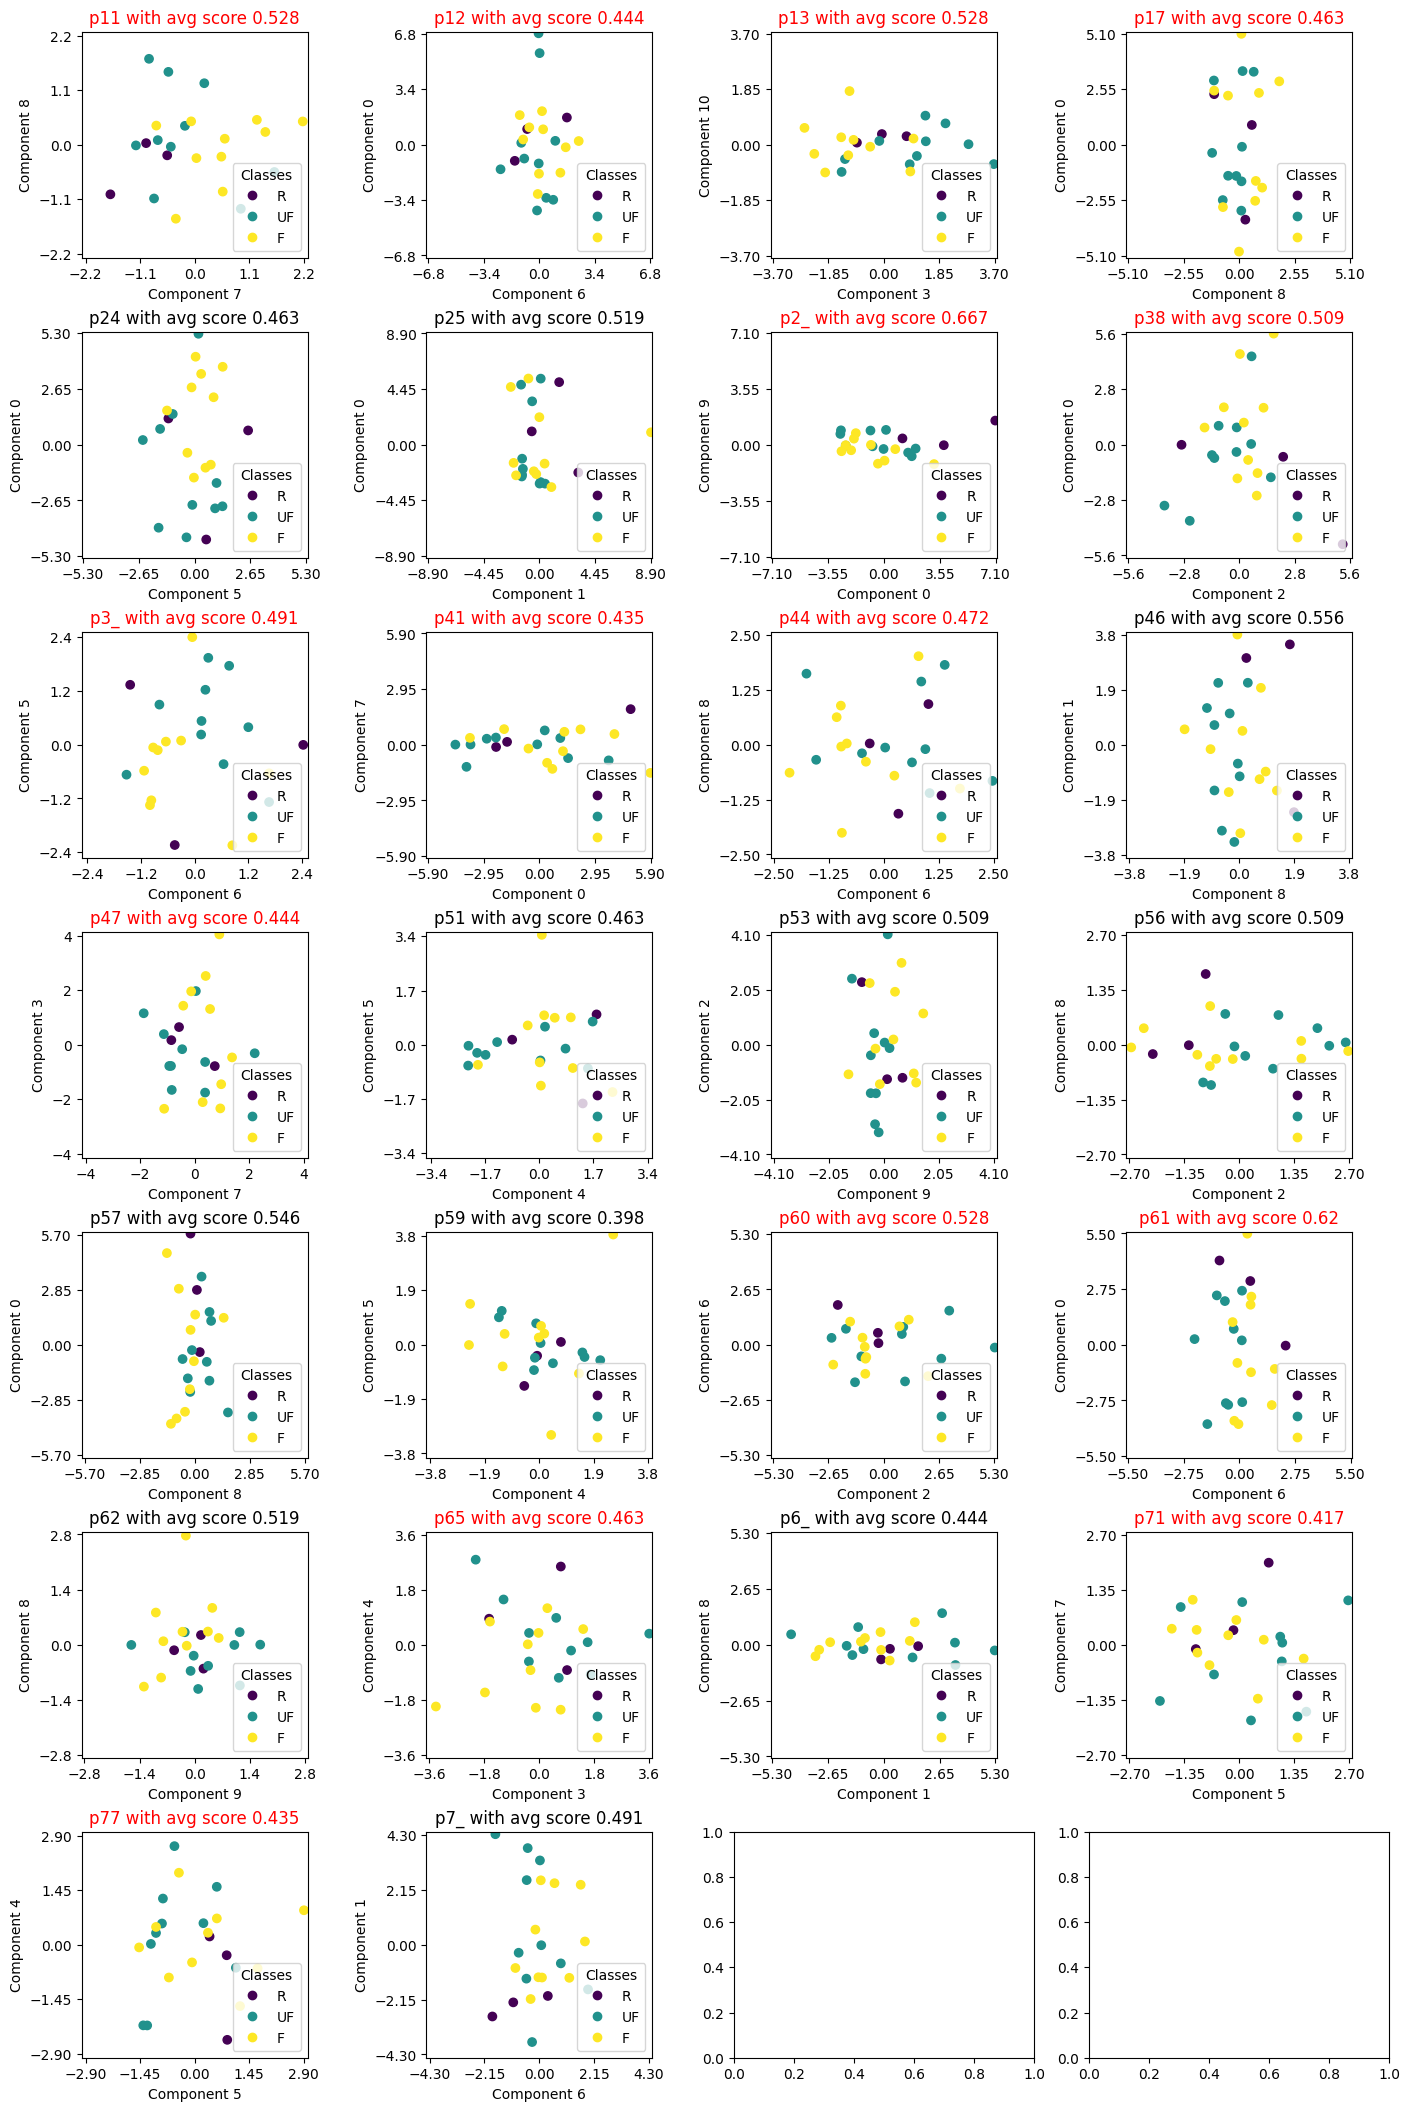

In [40]:
fig, axes = plt.subplots(7,4, figsize=(14,21), constrained_layout=True)
for i,ax in zip(range(len(people)),axes.ravel()):
    y1 = np.array(pd.Series(all_data[i]['Event'],dtype=t).cat.codes)
    n_components = 0.95
    pca = sklearn.decomposition.PCA(n_components=n_components)
    train_X = all_data[i][m_list]
    #print(train_X.shape)
    train_X = sklearn.preprocessing.StandardScaler().fit(train_X).transform(train_X)
    train_X = pca.fit_transform(train_X)
    first_feature = subsets_list[i][1]['feature_idx'][0]
    second_feature = [*subsets_list[i][2]['feature_idx']]
    second_feature.remove(first_feature)
    second_feature = second_feature[0]
    #print(len(y1), len(train_X[first_feature]))
    scatter = ax.scatter(train_X[:,first_feature], train_X[:,second_feature], c=y1)
    max_val = np.max(np.append(abs(train_X[:,first_feature]),abs(train_X[:,second_feature]))) 
    ax.set_ylim(-max_val-0.1,max_val+0.1)
    ax.set_xlim(-max_val-0.1,max_val+0.1)
    ax.set_xticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])
    ax.set_yticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])
    xlabel = 'Component ' + str(first_feature)
    ylabel = 'Component ' + str(second_feature)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_aspect('equal', adjustable=None, anchor=None, share=False)
    ax.legend(
        scatter.legend_elements()[0],
        ['R', 'UF', 'F'],
        title="Classes",
        loc = 'lower right'
    )
    if patient_numbers[people[i]] in intersection:
        color = 'r'
    else:
        color = 'k'
    title = str(patient_numbers[people[i]]) + ' with avg score ' + str(round(subsets_list[i][2]['avg_score'],3))
    ax.set_title(title, color=color)

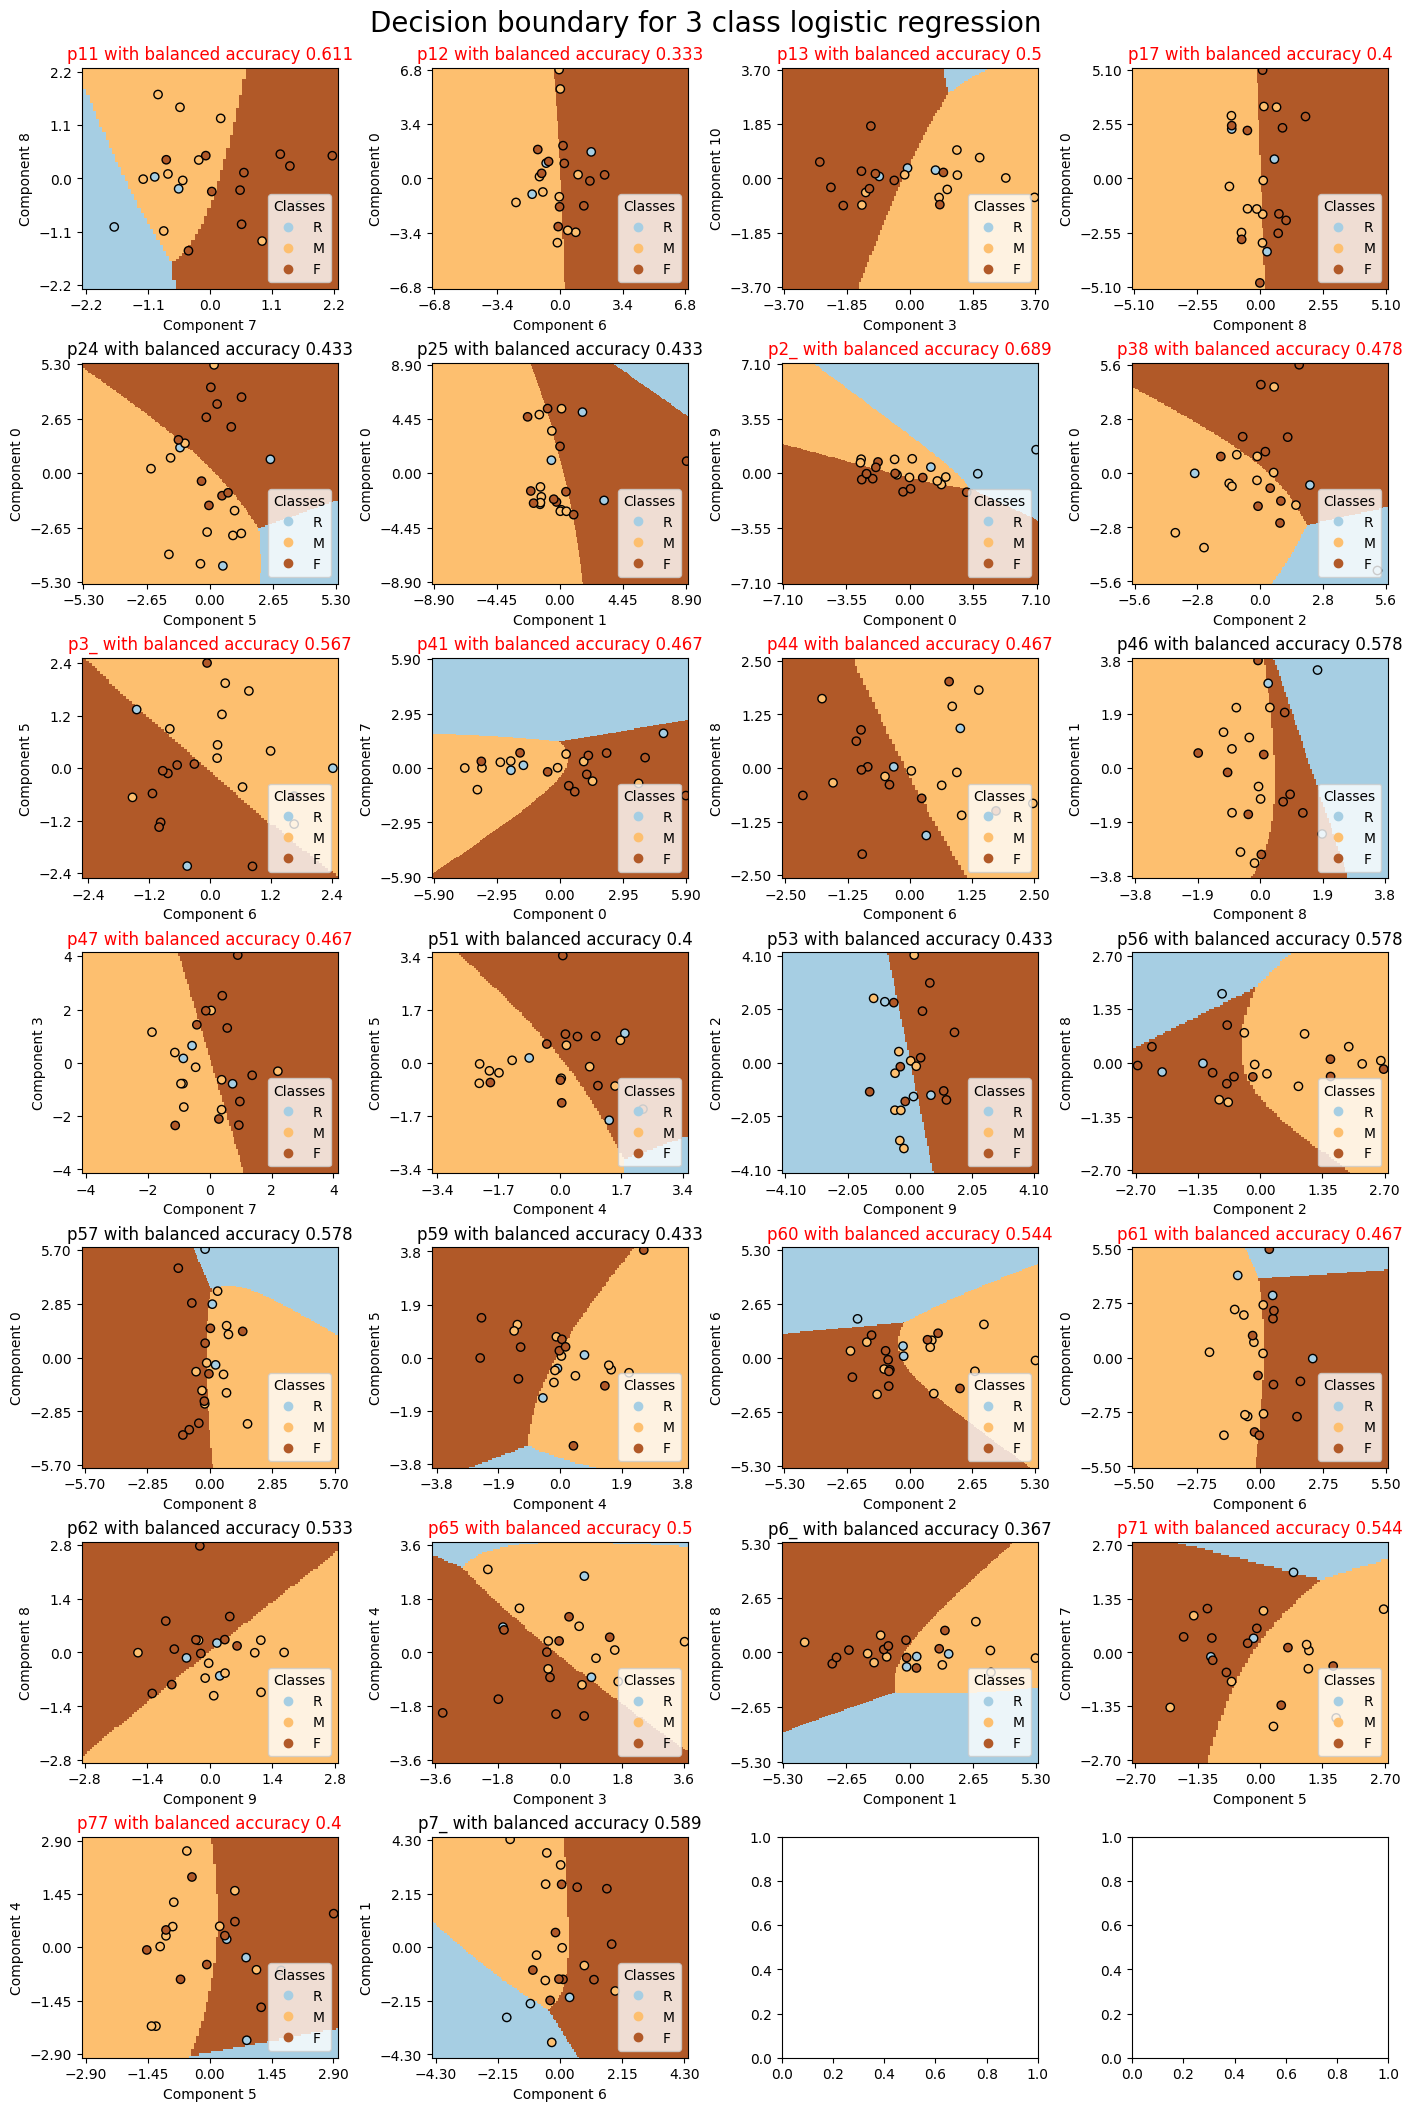

In [70]:
#three-class
#good plots
#cmap = matplotlib.colors.ListedColormap(["gold", "crimson", "indigo"])

fig, axes = plt.subplots(7,4, figsize=(14,21), constrained_layout=True)
fig.suptitle('Decision boundary for 3 class logistic regression', fontsize=20)

for i,ax in zip(range(len(people)),axes.ravel()):
    y1 = np.array(pd.Series(all_data[i]['Event'],dtype=t).cat.codes)
    #train_y2 = [x if x==1 or x==0 else 1 for x in train_y]
    train_y2 = y1
    n_components = 0.95
    pca = sklearn.decomposition.PCA(n_components=n_components)
    train_X = all_data[i][m_list]
    #print(train_X.shape)
    train_X = sklearn.preprocessing.StandardScaler().fit(train_X).transform(train_X)
    train_X = pca.fit_transform(train_X)
    first_feature = subsets_list[i][1]['feature_idx'][0]
    second_feature = [*subsets_list[i][2]['feature_idx']]
    second_feature.remove(first_feature)
    second_feature = second_feature[0]
    train_X = pd.DataFrame(train_X[:,[first_feature, second_feature]], columns=[first_feature, second_feature])
    ord_clf = OrdinalClassifier(estimator=LogisticRegression(multi_class='multinomial'))
    #ord_clf = LogisticRegression()
    #print(len(y1), len(train_X[first_feature]))
    names = ['R', 'M', 'F']
    ord_clf.fit(train_X, train_y2)
    predictions = ord_clf.predict(train_X)
   
    score1 = balanced_accuracy_score(train_y2, predictions)
    #predictions = ord_clf.predict(train_X)
    #predictions = [x if x==1 or x==0 else 1 for x in predictions]
    #two_class_score = [predictions[i]==train_y2[i] for i in range(len(predictions))]
    #two_class_score = np.array(two_class_score).sum()/len(predictions)
    xlabel = 'Component ' + str(first_feature)
    ylabel = 'Component ' + str(second_feature)
    disp = DecisionBoundaryDisplay.from_estimator(ord_clf, train_X,grid_resolution=600,ax=ax, response_method="predict",plot_method="pcolormesh",shading="auto",xlabel=xlabel,ylabel=ylabel,eps=15, cmap=plt.cm.Paired)
    scatter = disp.ax_.scatter(train_X.iloc[:,0],train_X.iloc[:,1], c=train_y, edgecolors='k', cmap=plt.cm.Paired)
    max_val = np.max(np.append(abs(train_X.iloc[:,0]),abs(train_X.iloc[:,1]))) 
    disp.ax_.set_ylim(-max_val-0.1,max_val+0.1)
    disp.ax_.set_xlim(-max_val-0.1,max_val+0.1)
    disp.ax_.set_xticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])
    disp.ax_.set_yticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])
    
    #disp.ax_.set_xlim(-3,3)
    #disp.ax_.set_ylim(-3,3)
    disp.ax_.legend(
        scatter.legend_elements()[0],
        names,
        title="Classes",
        loc = 'lower right'
    )
    if patient_numbers[people[i]] in intersection:
        color = 'r'
    else:
        color = 'k'
    title = str(patient_numbers[people[i]]) + ' with balanced accuracy ' + str(round(score1,3))
    ax.set_title(title, color=color)
plt.show()

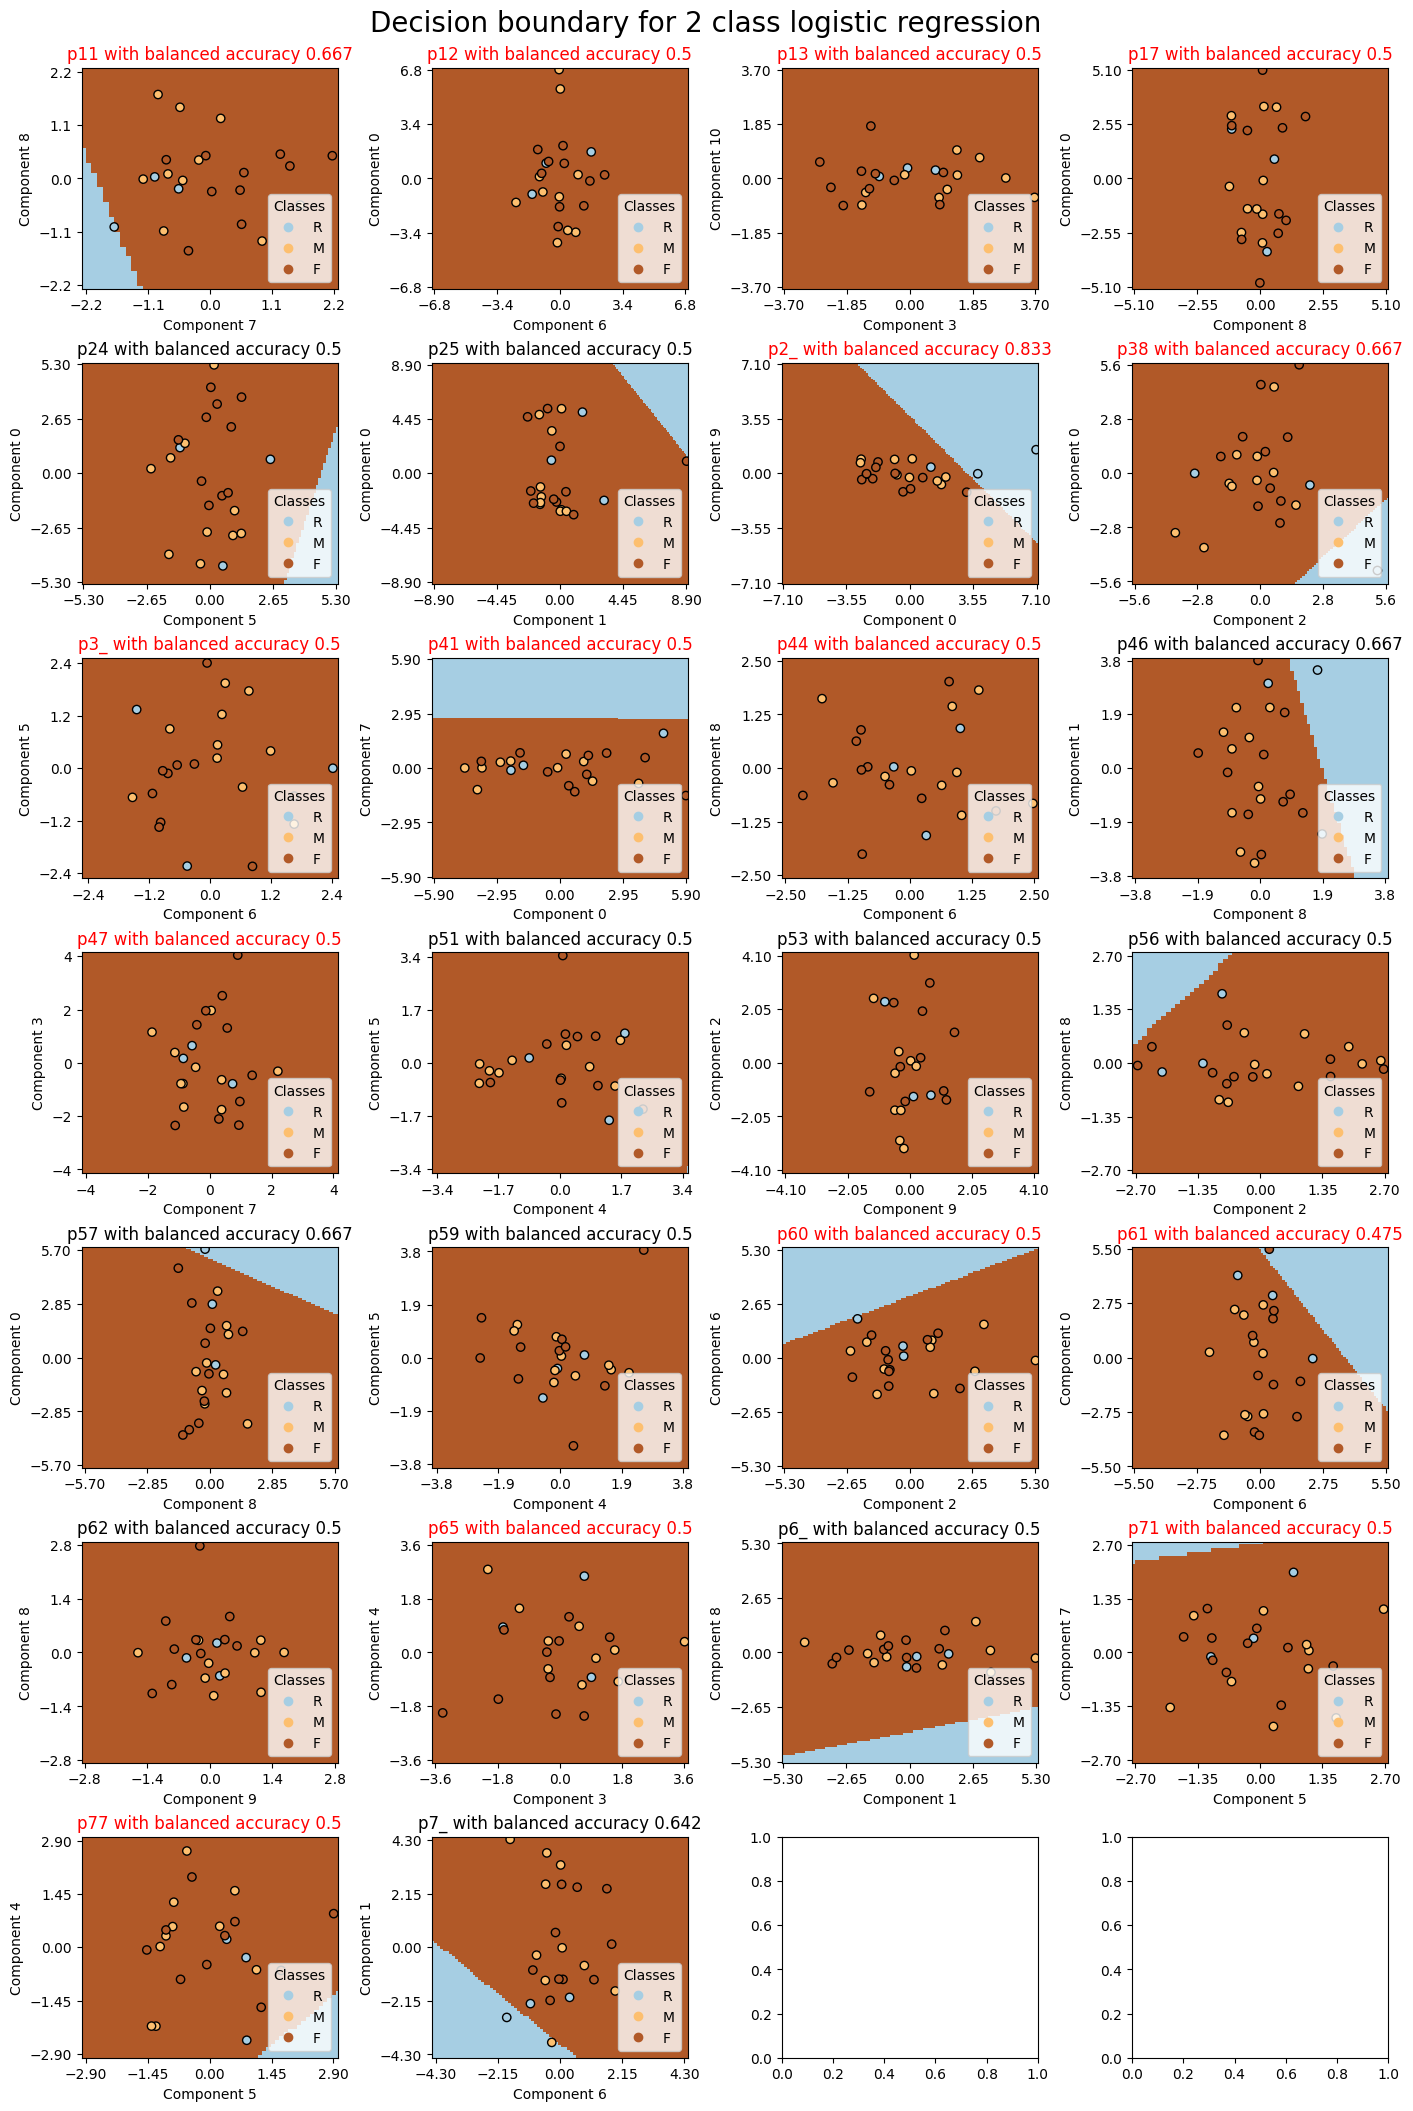

In [71]:
#two-class
#good plots
import matplotlib.colors
#cmap = matplotlib.colors.ListedColormap(["gold", "crimson", "indigo"])

fig, axes = plt.subplots(7,4, figsize=(14,21), constrained_layout=True)
fig.suptitle('Decision boundary for 2 class logistic regression', fontsize=20)

for i,ax in zip(range(len(people)),axes.ravel()):
    y1 = np.array(pd.Series(all_data[i]['Event'],dtype=t).cat.codes)
    train_y2 = [x if x==1 or x==0 else 1 for x in train_y]
    #train_y2 = y1
    n_components = 0.95
    pca = sklearn.decomposition.PCA(n_components=n_components)
    train_X = all_data[i][m_list]
    #print(train_X.shape)
    train_X = sklearn.preprocessing.StandardScaler().fit(train_X).transform(train_X)
    train_X = pca.fit_transform(train_X)
    first_feature = subsets_list[i][1]['feature_idx'][0]
    second_feature = [*subsets_list[i][2]['feature_idx']]
    second_feature.remove(first_feature)
    second_feature = second_feature[0]
    train_X = pd.DataFrame(train_X[:,[first_feature, second_feature]], columns=[first_feature, second_feature])
    #ord_clf = OrdinalClassifier(estimator=LogisticRegression(multi_class='multinomial'))
    ord_clf = LogisticRegression()
    #print(len(y1), len(train_X[first_feature]))
    names = ['R', 'M', 'F']
    ord_clf.fit(train_X, train_y2)
    predictions = ord_clf.predict(train_X)
    score1 = balanced_accuracy_score(train_y2, predictions)    
    #predictions = ord_clf.predict(train_X)
    #predictions = [x if x==1 or x==0 else 1 for x in predictions]
    #two_class_score = [predictions[i]==train_y2[i] for i in range(len(predictions))]
    #two_class_score = np.array(two_class_score).sum()/len(predictions)
    xlabel = 'Component ' + str(first_feature)
    ylabel = 'Component ' + str(second_feature)
    disp = DecisionBoundaryDisplay.from_estimator(ord_clf, train_X,grid_resolution=2000,ax=ax, response_method="predict",plot_method="pcolormesh",shading="auto",xlabel=xlabel,ylabel=ylabel,eps=100, cmap=plt.cm.Paired)
    scatter = disp.ax_.scatter(train_X.iloc[:,0],train_X.iloc[:,1], c=train_y, edgecolors='k', cmap=plt.cm.Paired)
    max_val = np.max(np.append(abs(train_X.iloc[:,0]),abs(train_X.iloc[:,1]))) 
    disp.ax_.set_ylim(-max_val-0.1,max_val+0.1)
    disp.ax_.set_xlim(-max_val-0.1,max_val+0.1)
    disp.ax_.set_xticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])
    disp.ax_.set_yticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])
    disp.ax_.legend(
        scatter.legend_elements()[0],
        names,
        title="Classes",
        loc = 'lower right'
    )
    if patient_numbers[people[i]] in intersection:
        color = 'r'
    else:
        color = 'k'
    title = str(patient_numbers[people[i]]) + ' with balanced accuracy ' + str(round(score1,3))
    ax.set_title(title, color=color)
plt.show()

# Old code below

Visualize average crossvalidation scores and see chosen features based on good models

[ 1 28 35 39 41 43 51 52 58 69 72]
['p11', 'p38', 'p44', 'p48', 'p4_', 'p51', 'p5_', 'p60', 'p67', 'p79', 'p8_']
(1, 4)
(3, 4)
(1, 4)
(3, 4)
(0, 1)
(2, 5)
(4, 5)
(0, 3)
(1, 2)
(3, 5)
(2, 3)
(0, 2)
(2, 5)
(2, 3)
(0, 5)
(1, 4)
(1, 5)
(0, 3)
(1, 3)
(2, 5)
(2, 5)
[(0, 2), (1, 4), (2, 3), (3, 5), (4, 5), (5, 3)]
----------------


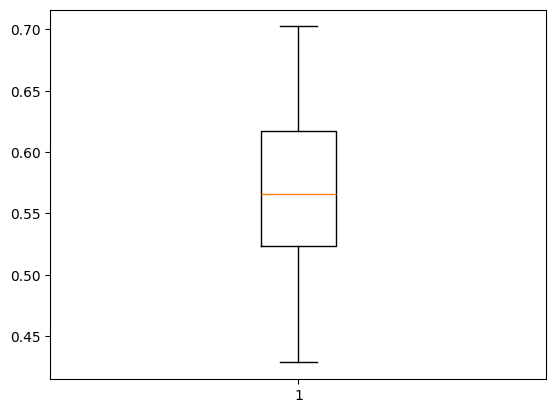

In [56]:
plt.boxplot(scores)

good = np.where(np.asarray(scores)>=0.65)[0]
bad = np.where(np.asarray(scores)<=0.50)[0]

print(good)
print([patient_numbers[i] for i in good])

minority = []
majority = []
for i in good:
    print(chosen_features_list[i])
    majority.append(chosen_features_list[i])
for i in bad:
    print(chosen_features_list[i])
    minority.append(chosen_features_list[i])
major = list(zip(*np.unique(majority, return_counts=True)))
print(major)
print('----------------')
#print(chosen_features_list)


In [57]:
print(majority)

[(1, 4), (3, 4), (1, 4), (3, 4), (0, 1), (2, 5), (4, 5), (0, 3), (1, 2), (3, 5), (2, 3)]


In [58]:
print(components_list[28].shape)

(6, 25)


In [59]:
print(good)

[ 1 28 35 39 41 43 51 52 58 69 72]


In [1]:
print(20+13+11+1+9+8)

62


In [60]:
print([explained_var[i] for i in good])

[array([0.26229864, 0.21164427, 0.12922953, 0.09377741, 0.08016208,
       0.05552446]), array([0.4920746 , 0.13443791, 0.08884312, 0.06600503, 0.05001552,
       0.03808975]), array([0.23625098, 0.13597204, 0.11200356, 0.10478641, 0.08647623,
       0.05951458]), array([0.31631073, 0.1714011 , 0.11766697, 0.09424069, 0.06590889,
       0.05962012]), array([0.38198345, 0.16968597, 0.1165732 , 0.08450227, 0.06647165,
       0.04808576]), array([0.26410059, 0.15486619, 0.11634507, 0.10719667, 0.06651545,
       0.05749281]), array([0.24423307, 0.1797758 , 0.14764131, 0.11086605, 0.07734909,
       0.05481078]), array([0.26660676, 0.19828824, 0.12865449, 0.08587188, 0.06825847,
       0.05615358]), array([0.28302334, 0.19199978, 0.13904245, 0.08985903, 0.07362421,
       0.05572026]), array([0.25361079, 0.17055553, 0.13630272, 0.08474047, 0.07304859,
       0.06242564]), array([0.32266209, 0.15093636, 0.12474964, 0.08530081, 0.07653434,
       0.06169416])]


In [44]:
majority

[(1, 4),
 (3, 4),
 (1, 4),
 (3, 4),
 (0, 1),
 (2, 5),
 (4, 5),
 (0, 3),
 (1, 2),
 (3, 5),
 (2, 3)]

In [100]:
counter = 0
new_major = []
for i in good:

    components = components_list[i]
    sort1 = np.argsort(abs(np.array(components[majority[counter][0]])))[::-1]
    sort2 = np.argsort(abs(np.array(components[majority[counter][1]])))[::-1]
    #print([(components[0][i], m_list[i]) for i in range(25)])
    #print(components[0])
    print([(m_list[j], components[majority[counter][0]][j]) for j in sort1[0:5]])
    print([(m_list[j], components[majority[counter][1]][j]) for j in sort2[0:5]])
    print('---------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    
    for j in range(1):
        new_major.append(m_list[sort1[j]])
        new_major.append(m_list[sort2[j]])
    
    counter +=1


[('Beta_N', 0.3308439615618521), ('Kolmogorov', -0.32869017099474124), ('wSMI', -0.28952704390105055), ('Delta_N', -0.26835709468953367), ('MaxHR', 0.25232214893734145)]
[('freq_slope_std', 0.5121410958075906), ('Alpha', -0.3870063528066654), ('PE', -0.34983144491834595), ('SE', -0.2652452813150788), ('Alpha_N', -0.21792905655849795)]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
[('PE', 0.39139470742831484), ('Kolmogorov', 0.3152583329601833), ('MSF', -0.31220858842874555), ('Delta_N', -0.2530191822427807), ('MeanRR', 0.24837335984546507)]
[('wSMI', 0.7760036463867309), ('Kolmogorov', 0.35584687633090767), ('PE', -0.27040116859443136), ('MSF', -0.22873511463689175), ('MeanRR', 0.17577903048844698)]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
[('Al

In [102]:
major2 = list(zip(*np.unique(new_major, return_counts=True)))
print(major2)
sort = sorted(major2, key = lambda x: x[1])[::-1]
print(sort)
chosen_features2 = ['freq_slope_mean', 'wSMI']

[('Alpha', 1), ('Alpha_N', 1), ('Beta', 2), ('Beta_N', 1), ('Delta', 1), ('Delta_N', 1), ('Gamma', 2), ('Kolmogorov', 1), ('PE', 1), ('SE', 1), ('StdHR', 2), ('Theta', 1), ('freq_slope_mean', 3), ('freq_slope_std', 2), ('wSMI', 2)]
[('freq_slope_mean', 3), ('wSMI', 2), ('freq_slope_std', 2), ('StdHR', 2), ('Gamma', 2), ('Beta', 2), ('Theta', 1), ('SE', 1), ('PE', 1), ('Kolmogorov', 1), ('Delta_N', 1), ('Delta', 1), ('Beta_N', 1), ('Alpha_N', 1), ('Alpha', 1)]


In [51]:
print([scores[g] for g in good])

[0.6547619047619048, 0.7023809523809524, 0.6607142857142857, 0.6547619047619048, 0.6547619047619048, 0.6964285714285715, 0.6904761904761904, 0.6607142857142857, 0.6607142857142857, 0.6547619047619048, 0.6547619047619048]


In [52]:
print(minority)
print(bad)

[(0, 2), (2, 5), (2, 3), (0, 5), (1, 4), (1, 5), (0, 3), (1, 3), (2, 5), (2, 5)]
[14 20 37 38 40 48 55 65 67 71]


In [65]:
print([*majority[0]])

[1, 4]


(23, 6)
(23, 6)
(23, 6)
(23, 6)
(23, 6)
(23, 6)
(23, 6)
(23, 6)
(23, 6)
(23, 6)
(23, 6)


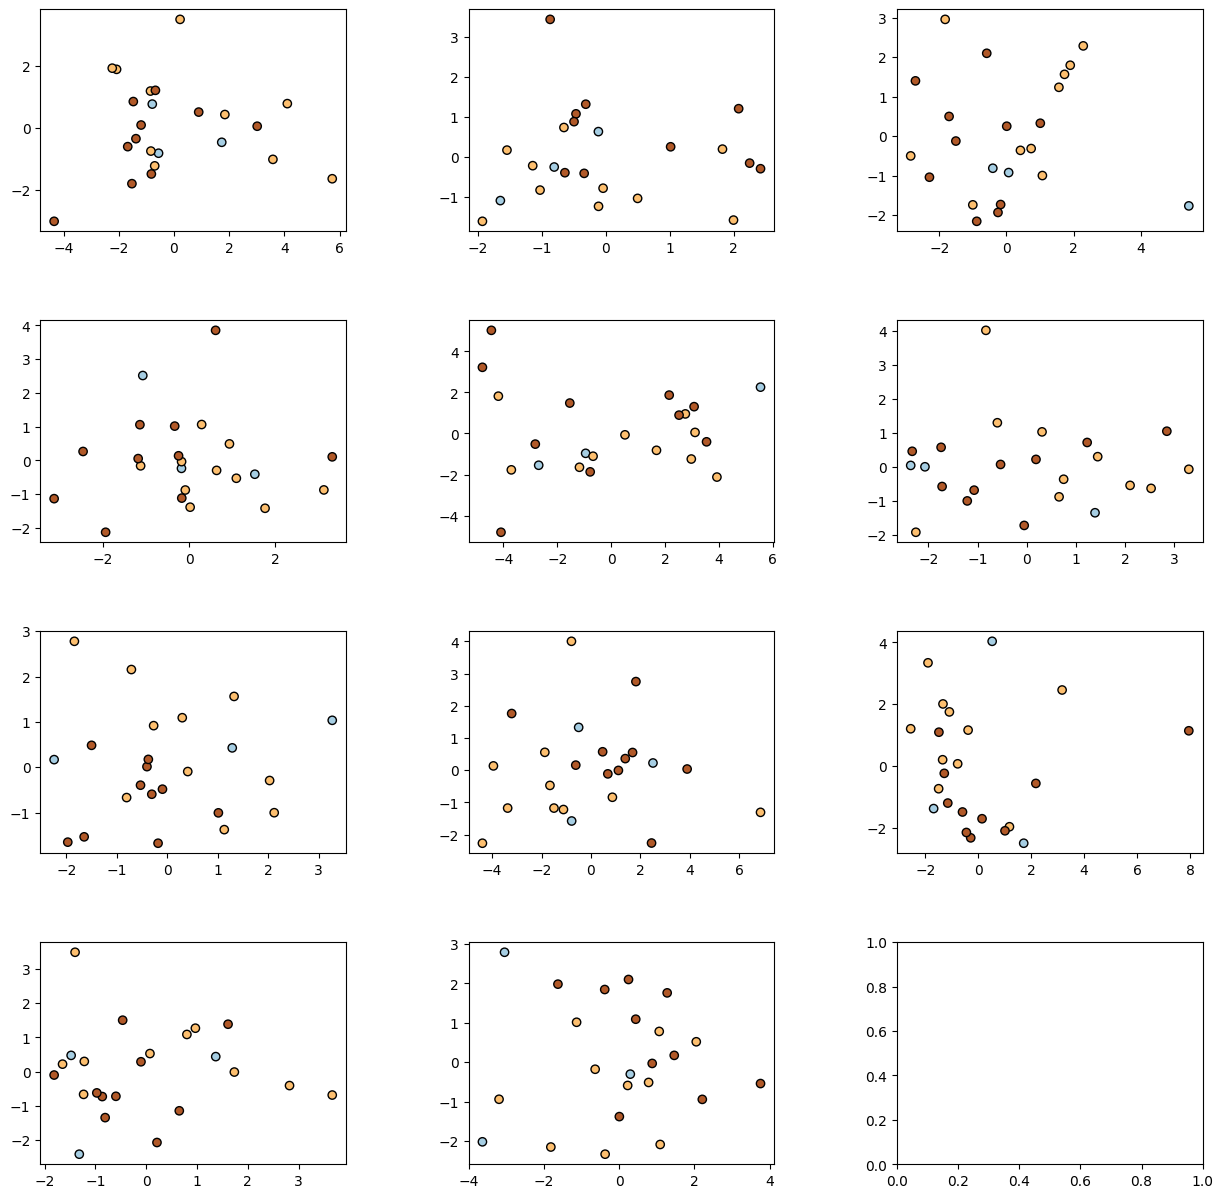

In [72]:
_, ax = plt.subplots(4,3,figsize=(15, 15))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
ax_list = [ax[0,0], ax[0,1], ax[0,2], ax[1,0], ax[1,1], ax[1,2], ax[2,0], ax[2,1],ax[2,2], ax[3,0], ax[3,1], ax[3,2]]
for i in range(11):
    person = good[i]
    train_y = pd.Series(all_data[person]['Event'],dtype=t).cat.codes
    #print(train_y)
    train_X = all_data[person][m_list]
    pca = sklearn.decomposition.PCA(n_components=n_components)
    train_X = sklearn.preprocessing.StandardScaler().fit(train_X).transform(train_X)
    train_X = pca.fit_transform(train_X)
    #print(train_X.shape)
    train_X = pd.DataFrame(train_X[:,[*majority[i]]], columns=[*majority[i]])
    #print(train_X)
    #ord_clf = OrdinalClassifier(estimator=LogisticRegression(multi_class='multinomial'))
    #ord_clf = LogisticRegression()
    names = ['R', 'M', 'F']
    #ord_clf.fit(train_X, train_y)
    #score1 = ord_clf.score(train_X,train_y)
    ax = ax_list[i]
    #disp = DecisionBoundaryDisplay.from_estimator(ord_clf,train_X,ax=ax_list[i],response_method="predict",plot_method="pcolormesh",shading="auto",xlabel=features1[0],ylabel=features1[1],eps=0.5,cmap=plt.cm.Paired)
    ax.scatter(train_X.iloc[:,0],train_X.iloc[:,1], c=train_y, edgecolors='k',cmap=plt.cm.Paired)
    """ax.legend(
        scatter.legend_elements()[0],
        names,
        title="Classes",
    )"""
    #title = str(patient_numbers[person]) +' with score '+str(np.round(score1,3))
plt.show()

C:\Users\KSOE0397\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


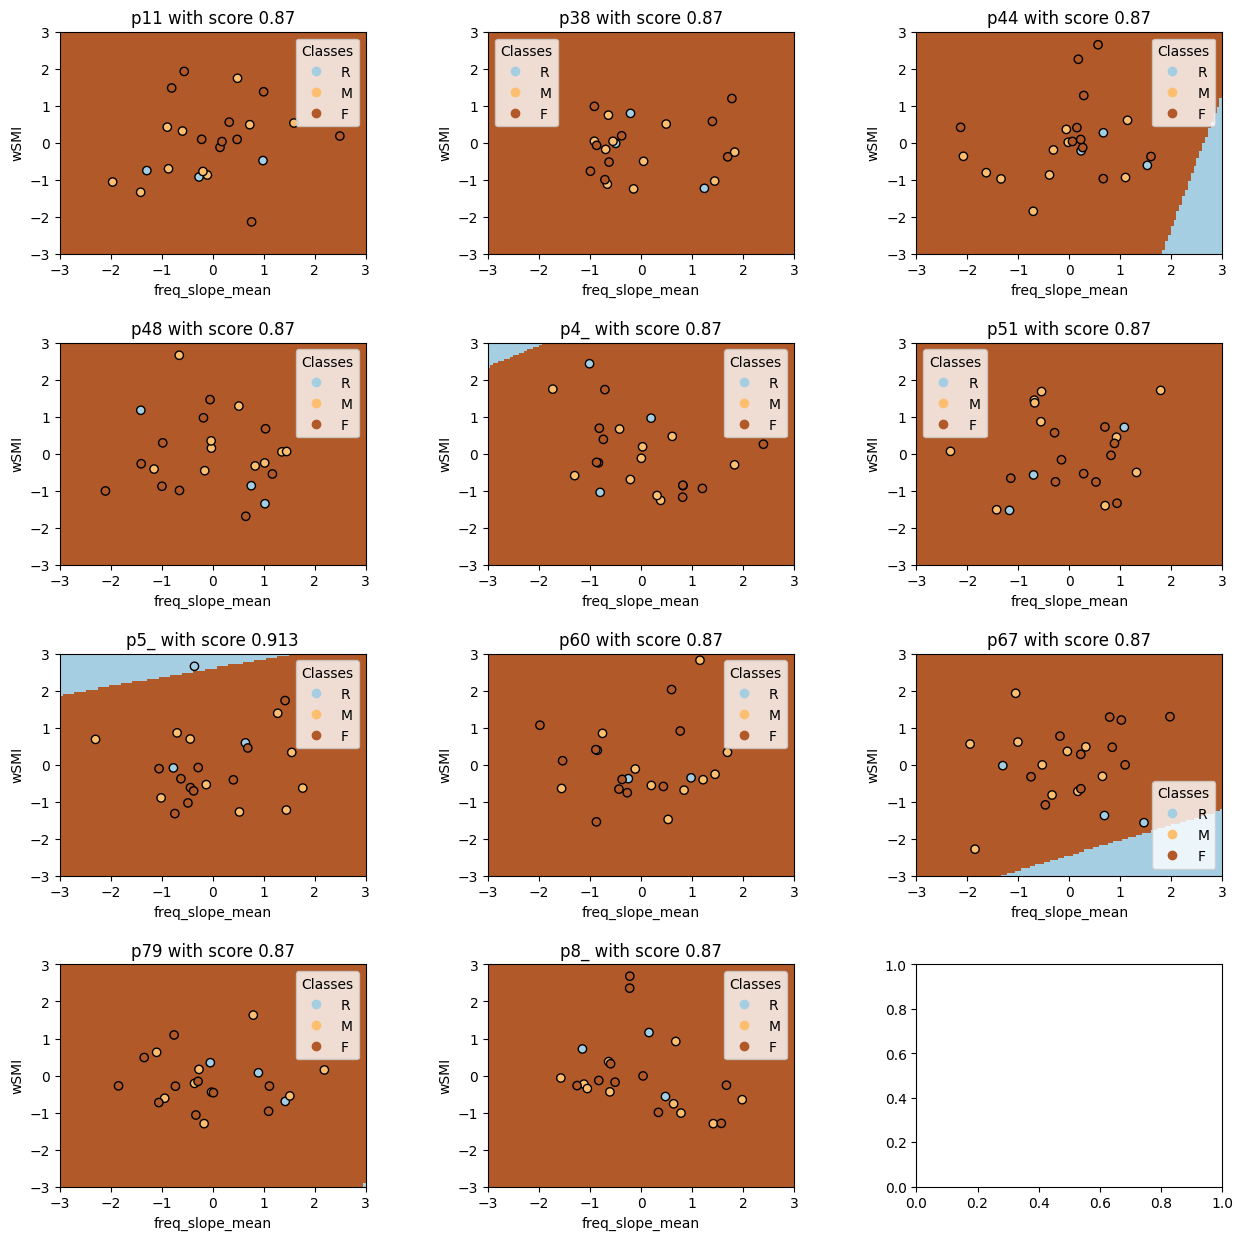

In [132]:
#two-class
#good plots
import matplotlib.colors
#cmap = matplotlib.colors.ListedColormap(["gold", "crimson", "indigo"])

_, ax = plt.subplots(4,3,figsize=(15, 15))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
ax_list = [ax[0,0], ax[0,1], ax[0,2], ax[1,0], ax[1,1], ax[1,2], ax[2,0], ax[2,1],ax[2,2], ax[3,0], ax[3,1], ax[3,2]]
for i in range(11):
    person = good[i]
    features1 = chosen_features2
    train_y = pd.Series(all_data[person]['Event'],dtype=t).cat.codes
    train_y2 = [x if x==1 or x==0 else 1 for x in train_y]

    #print(train_y)
    train_X = all_data[person][features1]
    train_X = pd.DataFrame(sklearn.preprocessing.StandardScaler().fit(train_X).transform(train_X), columns=features1)
    #print(train_X)
    #ord_clf = OrdinalClassifier(estimator=LogisticRegression(multi_class='multinomial'))
    ord_clf = LogisticRegression()
    names = ['R', 'M', 'F']
    ord_clf.fit(train_X, train_y2)
    score1 = ord_clf.score(train_X,train_y2)
    #predictions = ord_clf.predict(train_X)
    #predictions = [x if x==1 or x==0 else 1 for x in predictions]
    #two_class_score = [predictions[i]==train_y2[i] for i in range(len(predictions))]
    #two_class_score = np.array(two_class_score).sum()/len(predictions)
    disp = DecisionBoundaryDisplay.from_estimator(ord_clf, train_X,grid_resolution=600,ax=ax_list[i], response_method="predict",plot_method="pcolormesh",shading="auto",xlabel=features1[0],ylabel=features1[1],eps=15, cmap=plt.cm.Paired)
    scatter = disp.ax_.scatter(train_X.iloc[:,0],train_X.iloc[:,1], c=train_y, edgecolors='k', cmap=plt.cm.Paired)
    disp.ax_.set_xlim(-3,3)
    disp.ax_.set_ylim(-3,3)
    disp.ax_.legend(
        scatter.legend_elements()[0],
        names,
        title="Classes",
    )
    title = str(patient_numbers[person]) +' with score '+str(np.round(score1,3))

    disp.ax_.set_title(title)
plt.show()

C:\Users\KSOE0397\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


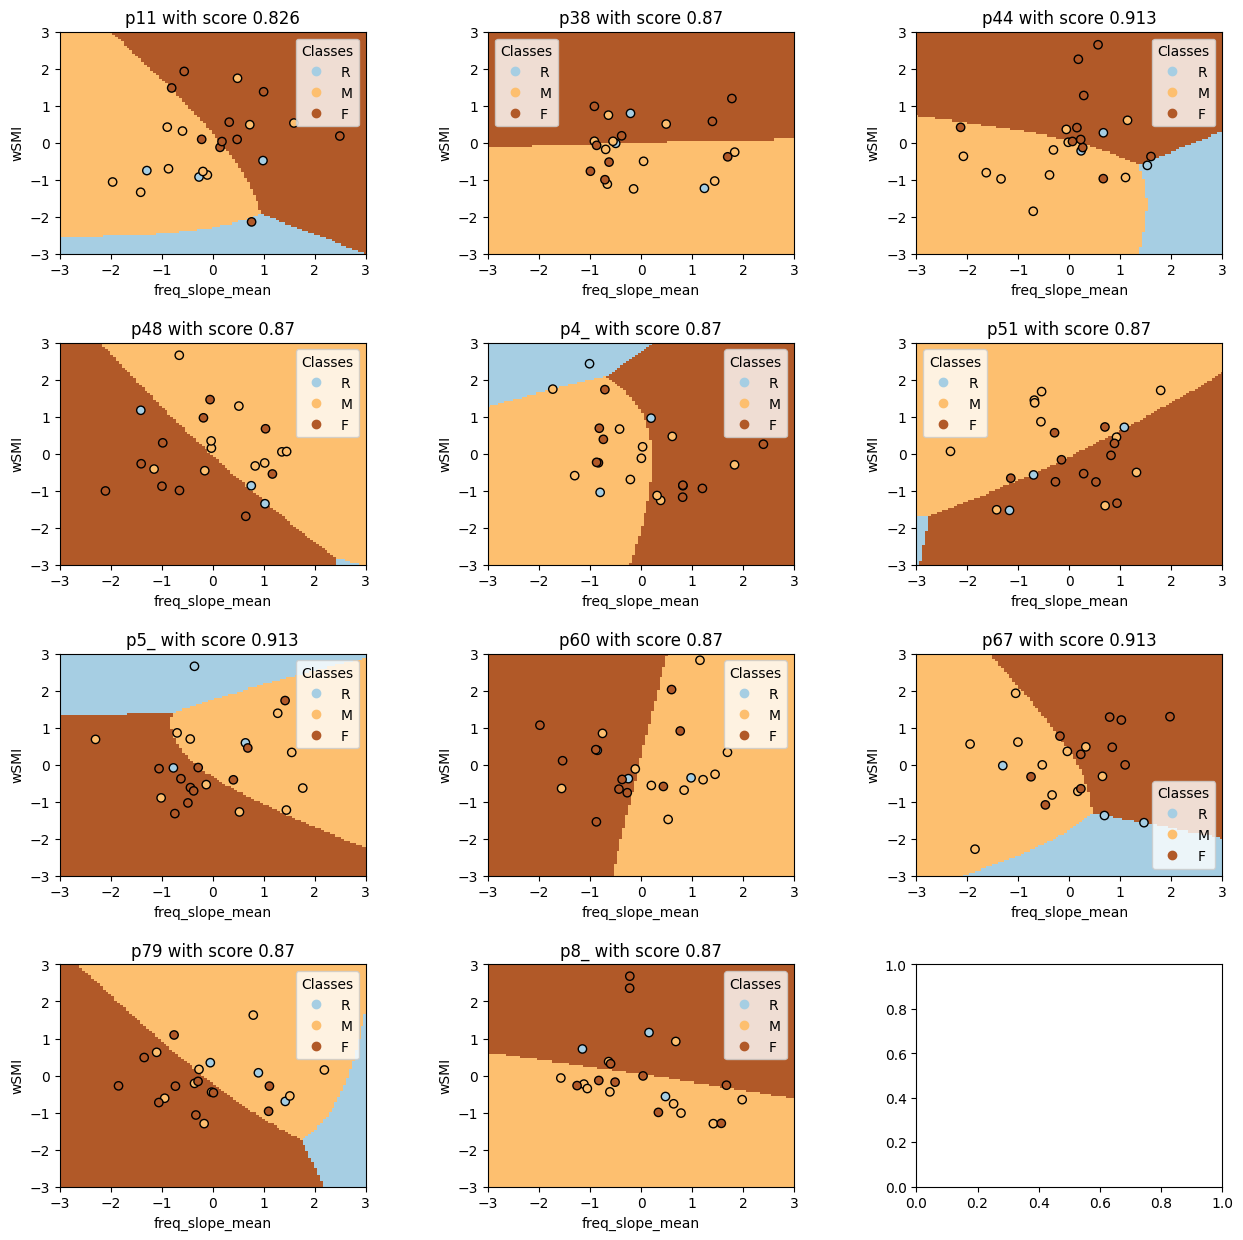

In [133]:
#good plots
_, ax = plt.subplots(4,3,figsize=(15, 15))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
ax_list = [ax[0,0], ax[0,1], ax[0,2], ax[1,0], ax[1,1], ax[1,2], ax[2,0], ax[2,1],ax[2,2], ax[3,0], ax[3,1], ax[3,2]]
for i in range(11):
    person = good[i]
    features1 = chosen_features2
    train_y = pd.Series(all_data[person]['Event'],dtype=t).cat.codes
    #print(train_y)
    train_X = all_data[person][features1]
    train_X = pd.DataFrame(sklearn.preprocessing.StandardScaler().fit(train_X).transform(train_X), columns=features1)
    #print(train_X)
    ord_clf = OrdinalClassifier(estimator=LogisticRegression(multi_class='multinomial'))
    #ord_clf = LogisticRegression()
    names = ['R', 'M', 'F']
    ord_clf.fit(train_X, train_y)
    score1 = ord_clf.score(train_X,train_y)
    predictions = ord_clf.predict(train_X)
    predictions = [x if x==1 or x==0 else 1 for x in predictions]
    train_y2 = [x if x==1 or x==0 else 1 for x in train_y]
    two_class_score = [predictions[i]==train_y2[i] for i in range(len(predictions))]
    two_class_score = np.array(two_class_score).sum()/len(predictions)
    disp = DecisionBoundaryDisplay.from_estimator(ord_clf, train_X,grid_resolution=600,ax=ax_list[i], response_method="predict",plot_method="pcolormesh",shading="auto",xlabel=features1[0],ylabel=features1[1],eps=15, cmap=plt.cm.Paired)
    scatter = disp.ax_.scatter(train_X.iloc[:,0],train_X.iloc[:,1], c=train_y, edgecolors='k', cmap=plt.cm.Paired)
    disp.ax_.set_xlim(-3,3)
    disp.ax_.set_ylim(-3,3)
    disp.ax_.legend(
        scatter.legend_elements()[0],
        names,
        title="Classes",
    )
    title = str(patient_numbers[person]) +' with two-class-score '+str(np.round(two_class_score,3))

    disp.ax_.set_title(title)
plt.show()

['p11', 'p38', 'p44', 'p48', 'p4_', 'p51', 'p5_', 'p60', 'p67', 'p79', 'p8_']


In [103]:
title = str(patient_numbers[0]) +' with score '+str(scores[0])
print(title)

p10 with score 0.6547619047619048


In [162]:
zeros = []
for i in range(len(all_data)):
    zeros.append((patient_numbers[i],(all_data[i] == 0.).sum().sum(),i))
print(zeros)
sort = sorted(zeros, key = lambda x: x[1])[::-1]
print(sort)


[('p10', 3, 0), ('p11', 3, 1), ('p12', 3, 2), ('p13', 3, 3), ('p14', 3, 4), ('p15', 3, 5), ('p16', 3, 6), ('p17', 3, 7), ('p18', 3, 8), ('p19', 3, 9), ('p20', 3, 10), ('p21', 3, 11), ('p22', 3, 12), ('p23', 3, 13), ('p24', 3, 14), ('p25', 3, 15), ('p27', 3, 16), ('p28', 47, 17), ('p29', 3, 18), ('p2_', 3, 19), ('p30', 84, 20), ('p31', 3, 21), ('p32', 3, 22), ('p33', 3, 23), ('p34', 3, 24), ('p35', 3, 25), ('p36', 3, 26), ('p37', 3, 27), ('p38', 3, 28), ('p39', 3, 29), ('p3_', 95, 30), ('p40', 3, 31), ('p41', 3, 32), ('p42', 3, 33), ('p43', 3, 34), ('p44', 6, 35), ('p45', 3, 36), ('p46', 3, 37), ('p47', 3, 38), ('p48', 3, 39), ('p49', 3, 40), ('p4_', 3, 41), ('p50', 3, 42), ('p51', 3, 43), ('p52', 3, 44), ('p53', 3, 45), ('p54', 3, 46), ('p56', 3, 47), ('p57', 3, 48), ('p58', 3, 49), ('p59', 3, 50), ('p5_', 3, 51), ('p60', 3, 52), ('p61', 3, 53), ('p62', 3, 54), ('p63', 3, 55), ('p65', 3, 56), ('p66', 3, 57), ('p67', 3, 58), ('p68', 3, 59), ('p69', 3, 60), ('p6_', 3, 61), ('p71', 3, 62)

In [166]:
person = bad[1]
features1 = chosen_features2
train_y = pd.Series(all_data[person]['Event'],dtype=t).cat.codes
#print(train_y)
train_X = all_data[17]
pd.set_option('display.max_columns', None)
display(train_X)
#train_X = pd.DataFrame(sklearn.preprocessing.StandardScaler().fit(train_X).transform(train_X), columns=features1)


,No.,Event,Delta,Delta_N,Theta,Theta_N,Alpha,Alpha_N,Beta,Beta_N,Gamma,Gamma_N,SE,MSF,Sef90,Sef95,PE,wSMI,Kolmogorov,MeanRR,StdRR,MeanHR,StdHR,MinHR,MaxHR,freq_slope_mean,freq_slope_std
0,0,R,-117.305539,0.001426,-121.483933,0.000216,-121.824525,0.000084,-114.753442,0.000603,-115.987040,0.000406,0.000332,0.047863,0.013629,0.000000,6.918878e-04,0.000000,0.003008,548.153846,2.648657,109.460596,0.453618,108.695652,110.294118,-3.091030,0.001199
1,1,R,-114.361173,0.001414,-129.765394,0.000101,-130.347503,0.000082,-127.726197,0.000152,-129.861007,0.000090,0.000303,0.000000,0.022256,0.024883,5.620931e-04,0.000000,0.005701,586.000000,2.889260,102.394868,0.415783,101.351351,103.448276,-3.346984,0.006275
2,2,R,-116.319768,0.001516,-129.686770,0.000256,-135.172689,0.000107,-128.429478,0.000503,-135.784728,0.000122,0.000712,0.000000,0.022256,0.050792,3.330669e-16,0.003216,0.007607,612.500000,3.599517,97.956539,0.522960,96.774194,98.684211,-3.144412,0.049968
3,0,M,-111.396582,0.000404,-131.035428,0.000056,-129.284508,0.000102,-120.965662,0.000207,-125.739933,0.000067,0.000173,0.000000,0.030135,0.000000,3.330669e-16,0.000000,0.003008,586.166667,3.116111,102.359159,0.466614,101.351351,103.448276,-3.264203,0.001982
4,1,M,-118.155462,0.001080,-124.504259,0.000201,-122.894637,0.000381,-125.061717,0.000389,-126.609877,0.000215,0.000244,0.030475,0.043575,0.000000,4.368242e-03,0.000000,0.009727,583.500000,3.599517,102.834167,0.562775,102.040816,104.166667,-2.992551,0.001028
5,2,M,-113.875870,0.000700,-127.258767,0.000163,-130.551995,0.000071,-124.309769,0.000208,-124.464686,0.000212,0.000326,0.000000,0.029790,0.065834,3.330669e-16,0.000000,0.003054,588.666667,3.472459,101.931997,0.529363,100.671141,102.739726,-3.450831,0.028530
6,3,M,-111.205773,0.000639,-126.127527,0.000079,-127.258232,0.000056,-124.809111,0.000126,-127.911715,0.000069,0.000111,0.000000,0.000000,0.033384,6.069916e-05,0.000483,0.004444,593.000000,3.175997,101.177767,0.475488,100.000000,102.040816,-3.215594,0.035413
7,4,M,-116.078091,0.004655,-127.575658,0.000453,-134.097783,0.000084,-124.984505,0.000721,-129.635165,0.000242,0.000692,0.000000,0.027258,0.682885,4.440892e-16,0.000000,0.006768,586.333333,3.522186,102.331011,0.532448,101.351351,103.448276,-3.227351,0.004633
8,5,M,-118.691563,0.002986,-125.563166,0.000590,-134.098335,0.000130,-129.478184,0.000285,-132.293100,0.000133,0.000412,0.000000,0.046773,0.022256,7.137484e-04,0.002460,0.005171,602.434783,3.565314,99.589736,0.479585,98.684211,100.671141,-3.152857,0.001476
9,6,M,-109.683579,0.000750,-124.113701,0.000120,-126.419468,0.000048,-122.692863,0.000117,-126.177569,0.000066,0.000227,0.000000,0.024883,0.028371,0.000000e+00,0.000000,0.010282,599.166667,7.269153,100.144994,1.139000,98.039216,102.040816,-2.436708,0.001085


C:\Users\KSOE0397\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


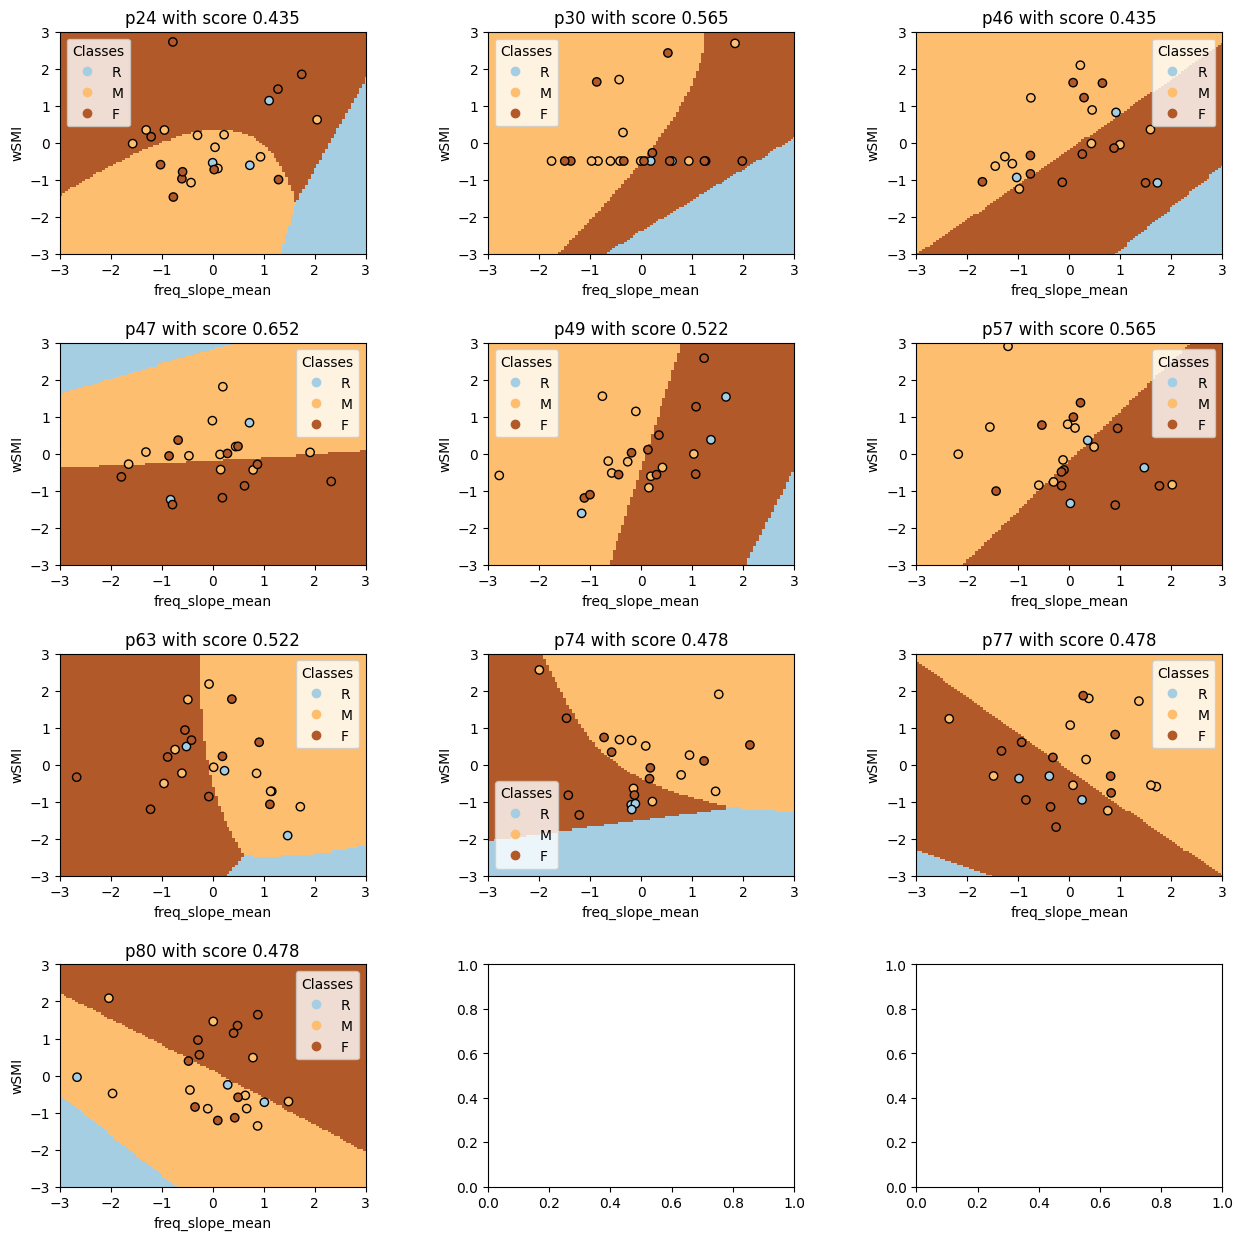

In [135]:
#good plots
_, ax = plt.subplots(4,3,figsize=(15, 15))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
ax_list = [ax[0,0], ax[0,1], ax[0,2], ax[1,0], ax[1,1], ax[1,2], ax[2,0], ax[2,1],ax[2,2], ax[3,0], ax[3,1], ax[3,2]]
for i in range(len(bad)):
    person = bad[i]
    features1 = chosen_features2
    train_y = pd.Series(all_data[person]['Event'],dtype=t).cat.codes
    #print(train_y)
    train_X = all_data[person][features1]
    train_X = pd.DataFrame(sklearn.preprocessing.StandardScaler().fit(train_X).transform(train_X), columns=features1)
    #print(train_X)
    ord_clf = OrdinalClassifier(estimator=LogisticRegression(multi_class='multinomial'))
    #ord_clf = LogisticRegression()
    names = ['R', 'M', 'F']
    ord_clf.fit(train_X, train_y)
    score1 = ord_clf.score(train_X,train_y)
    predictions = ord_clf.predict(train_X)
    predictions = [x if x==1 or x==0 else 1 for x in predictions]
    train_y2 = [x if x==1 or x==0 else 1 for x in train_y]
    two_class_score = [predictions[i]==train_y2[i] for i in range(len(predictions))]
    two_class_score = np.array(two_class_score).sum()/len(predictions)
    disp = DecisionBoundaryDisplay.from_estimator(ord_clf, train_X,grid_resolution=600,ax=ax_list[i], response_method="predict",plot_method="pcolormesh",shading="auto",xlabel=features1[0],ylabel=features1[1],eps=15, cmap=plt.cm.Paired)
    scatter = disp.ax_.scatter(train_X.iloc[:,0],train_X.iloc[:,1], c=train_y, edgecolors='k', cmap=plt.cm.Paired)
    disp.ax_.set_xlim(-3,3)
    disp.ax_.set_ylim(-3,3)
    disp.ax_.legend(
        scatter.legend_elements()[0],
        names,
        title="Classes",
    )
    title = str(patient_numbers[person]) +' with score '+str(np.round(score1,3))

    disp.ax_.set_title(title)
plt.show()

In [37]:
for x,y in major:
    print(x)

Alpha
Alpha_N
Beta
Delta
Delta_N
Gamma
MSF
MeanRR
PE
StdHR
StdRR
Theta
Theta_N
freq_slope_mean
freq_slope_std
wSMI


Inner loop, strat kfold

In [ ]:
chosen_features_list = []
for i in range(2):
    train_y = all_data[i]['Event']
    train_X = all_data[i][m_list]
    #print(train_X.shape,train_X)
    #print(train_y.shape,train_y)
    #skf = StratifiedKFold(n_splits=3)

    lr = LogisticRegression(multi_class='multinomial')
    sfs = SequentialFeatureSelector(lr, n_features_to_select=2, cv=3, scoring='accuracy') #cv = number of splits in crossval, automaticly it has stratifies kfold
    sfs.fit(train_X, train_y)
    chosen_features = sfs.get_feature_names_out(m_list) #get features
    trans_X = sfs.transform(train_X) #removing unnecessary features
    lr2 = LogisticRegression(multi_class='multinomial')
    lr2.fit(trans_X,train_y) #fitting to all training data
    coefficients = lr2.coef_
    avg_imp = np.mean(np.abs(coefficients),axis=0)
    feature_imp = pd.DataFrame({'Feature': chosen_features, 'Importance': avg_imp}).sort_values('Importance',ascending=True)#.plot(x='Feature', y='Importance', kind='barh')
    plt.show()
    chosen_features_list.append(chosen_features)
    
    print('Chosen features: ',chosen_features)


In [28]:
chosen_features_list

[array(['Delta', 'MaxHR'], dtype=object),
 array(['Theta_N', 'StdRR'], dtype=object),
 array(['MSF', 'MaxHR'], dtype=object),
 array(['Beta', 'MeanRR'], dtype=object),
 array(['Delta_N', 'StdHR'], dtype=object),
 array(['Beta', 'Gamma'], dtype=object),
 array(['MSF', 'MeanHR'], dtype=object),
 array(['Sef90', 'MaxHR'], dtype=object),
 array(['SE', 'wSMI'], dtype=object),
 array(['Delta_N', 'Theta_N'], dtype=object),
 array(['MSF', 'MeanRR'], dtype=object),
 array(['Alpha', 'Sef90'], dtype=object),
 array(['Theta', 'Gamma'], dtype=object),
 array(['MSF', 'Sef95'], dtype=object),
 array(['Delta_N', 'Theta'], dtype=object),
 array(['Delta', 'MaxHR'], dtype=object),
 array(['MSF', 'StdHR'], dtype=object),
 array(['Theta', 'MinHR'], dtype=object),
 array(['Alpha', 'StdRR'], dtype=object),
 array(['Beta', 'MaxHR'], dtype=object),
 array(['MSF', 'MinHR'], dtype=object),
 array(['Theta_N', 'StdHR'], dtype=object),
 array(['Theta', 'Alpha'], dtype=object),
 array(['Theta', 'StdRR'], dtype=objec

In [17]:
sort1 = np.argsort(abs(np.array(components[2])))[::-1]
sort2 = np.argsort(abs(np.array(components[3])))[::-1]
sort3 = np.argsort(abs(np.array(components[5])))[::-1]
markers_list = mean_list + std_list
print([markers_list[i] for i in sort1])
print([markers_list[i] for i in sort2])
print([markers_list[i] for i in sort3])

['PE_mean', 'wSMI_mean', 'Kolmogorov_mean', 'Delta_N_mean', 'Beta_N_mean', 'Beta_mean', 'Delta_mean', 'Alpha_N_mean', 'Gamma_mean', 'Alpha_mean', 'PE_std', 'Sef95_mean', 'wSMI_std', 'Gamma_N_mean', 'Sef90_mean', 'MinHR_std', 'freq_slope_mean_mean', 'MeanHR_std', 'MeanRR_mean', 'freq_slope_std_std', 'Delta_N_std', 'MeanRR_std', 'MinHR_mean', 'MeanHR_mean', 'SE_mean', 'Theta_N_mean', 'Delta_std', 'StdRR_mean', 'MSF_std', 'Gamma_N_std', 'Kolmogorov_std', 'MSF_mean', 'Theta_N_std', 'Theta_mean', 'Gamma_std', 'Beta_std', 'StdHR_mean', 'StdRR_std', 'Sef95_std', 'MaxHR_mean', 'SE_std', 'freq_slope_std_mean', 'Alpha_N_std', 'Beta_N_std', 'StdHR_std', 'Alpha_std', 'freq_slope_mean_std', 'Sef90_std', 'Theta_std', 'MaxHR_std']
['MaxHR_mean', 'Theta_mean', 'MaxHR_std', 'Delta_mean', 'Sef95_mean', 'Beta_N_mean', 'Beta_N_std', 'StdHR_mean', 'StdHR_std', 'MeanHR_mean', 'Theta_N_std', 'Theta_N_mean', 'Sef90_mean', 'MeanRR_mean', 'MSF_mean', 'PE_std', 'Beta_std', 'Gamma_std', 'Gamma_N_mean', 'SE_mean',

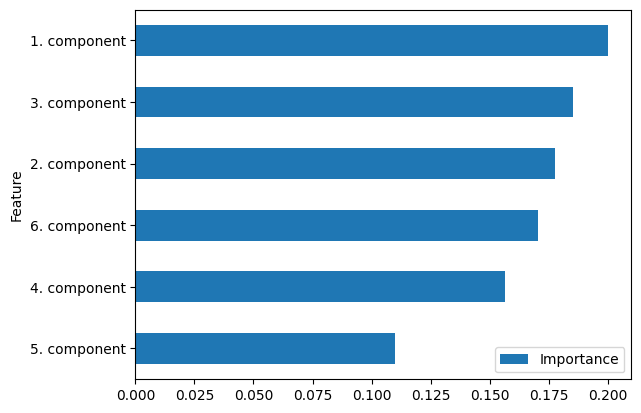

Chosen features:  ['3. component' '4. component' '6. component']
Score:  0.13636363636363635


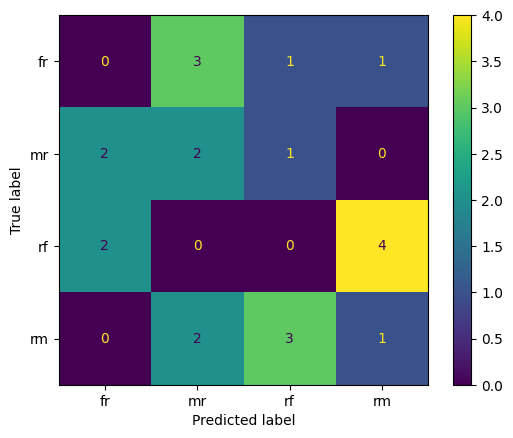

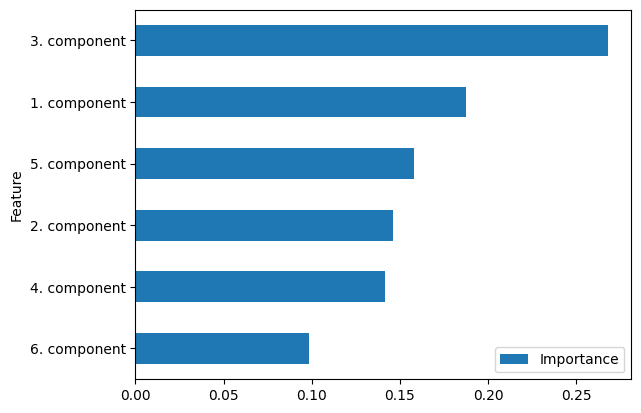

Chosen features:  ['3. component' '4. component' '6. component']
Score:  0.09090909090909091


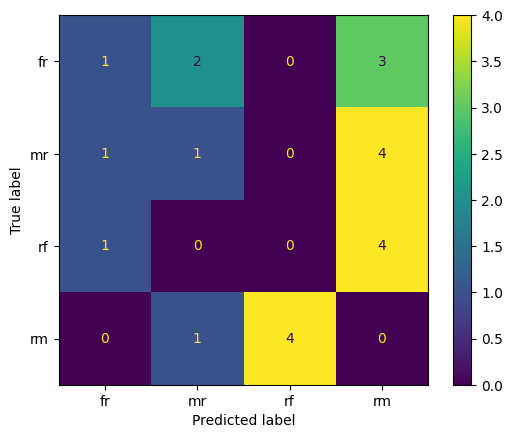

In [19]:
for i in range(len(outer_train_X)):
    train_y = outer_train_y[i]
    train_X = outer_train_X[i]
    #print(train_X.shape,train_X)
    #print(train_y.shape,train_y)
    #skf = StratifiedKFold(n_splits=3)

    lr = RandomForestClassifier(n_estimators=100, max_depth = 2)
    #sfs = SequentialFeatureSelector(lr, cv=3) #cv = number of splits in crossval, automaticly it has stratifies kfold
    #sfs.fit(train_X, train_y)
    #chosen_features = sfs.get_feature_names_out(mean_list+std_list) #get features
    #trans_X = sfs.transform(train_X) #removing unnecessary features
    #lr2 = RandomForestClassifier(n_estimators=10, max_depth = 2)
    
    lr.fit(train_X,train_y) #fitting to all training data
    coefficients = lr.feature_importances_
    feature_imp = pd.DataFrame({'Feature': [str(i) + '. component' for i in range(1,n_components+1)], 'Importance': coefficients}).sort_values('Importance',ascending=True).plot(x='Feature', y='Importance', kind='barh')
    plt.show()
    y_pred = lr.predict(outer_test_X[i])
    sklearn.metrics.ConfusionMatrixDisplay.from_predictions(outer_test_y[i], y_pred)
    score = lr.score(outer_test_X[i],outer_test_y[i]) #mean acc
    print('Chosen features: ',chosen_features)
    print('Score: ', score)